In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/SolarPrediction.csv'
data = pd.read_csv(file_path)

# Combine 'Data' and 'Time' into a single datetime column
data['Datetime'] = pd.to_datetime(data['Data'] + ' ' + data['Time'])

# Extract useful features from the datetime
data['Hour'] = data['Datetime'].dt.hour
data['Minute'] = data['Datetime'].dt.minute
data['Second'] = data['Datetime'].dt.second

# Drop unnecessary columns
data.drop(['UNIXTime', 'Data', 'Time', 'Datetime', 'TimeSunRise', 'TimeSunSet'], axis=1, inplace=True)

# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Target and features
X = data.drop(['Radiation'], axis=1).values  # Features
y = data['Radiation'].values  # Target


<ipython-input-2-88942aea3e89>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Datetime'] = pd.to_datetime(data['Data'] + ' ' + data['Time'])


Missing Values:
 Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Hour                      0
Minute                    0
Second                    0
dtype: int64


In [3]:
# Simple train-test split (80-20 split)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [4]:
# Linear Regression using Normal Equation
class LinearRegression:
    def __init__(self):
        self.theta = None

    def fit(self, X, y):
        # Add a bias term (intercept)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        # Normal equation: theta = (X.T * X)^-1 * X.T * y
        self.theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


Mean Absolute Error: 132.22


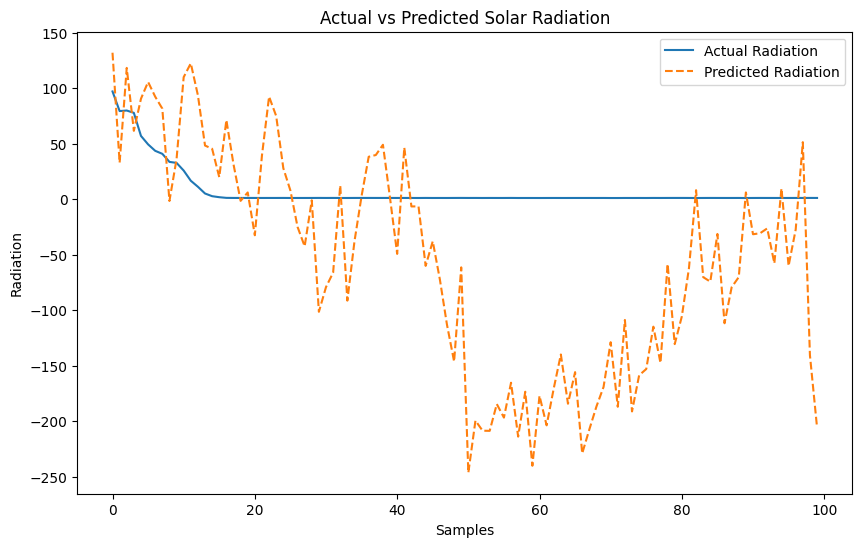

In [5]:
# Mean Absolute Error
mae = np.mean(np.abs(y_pred - y_test))
print(f"Mean Absolute Error: {mae:.2f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label="Actual Radiation")
plt.plot(y_pred[:100], label="Predicted Radiation", linestyle="--")
plt.legend()
plt.title("Actual vs Predicted Solar Radiation")
plt.xlabel("Samples")
plt.ylabel("Radiation")
plt.show()


In [6]:
# Calculate accuracy metrics
def calculate_metrics(y_true, y_pred):
    # Mean Squared Error
    mse = np.mean((y_pred - y_true) ** 2)
    # Root Mean Squared Error
    rmse = np.sqrt(mse)
    # Mean Absolute Error
    mae = np.mean(np.abs(y_pred - y_true))
    # R-squared
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)

    return mse, rmse, mae, r2

# Evaluate model on test data
mse, rmse, mae, r2 = calculate_metrics(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")


Mean Squared Error (MSE): 32711.08
Root Mean Squared Error (RMSE): 180.86
Mean Absolute Error (MAE): 132.22
R-squared (R²): 0.45


## **Now Using Deep Learning**

In [43]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.00001):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Xavier Initialization for weights
        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2. / (self.input_size + self.hidden_size))
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(2. / (self.hidden_size + self.output_size))

        # Bias initialization
        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.bias_output = np.zeros((1, self.output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)

    def forward(self, X):
        self.hidden_layer_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.relu(self.hidden_layer_input)

        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        return self.output_layer_input

    def backward(self, X, y, predictions):
        output_error = predictions - y.reshape(-1, 1)
        hidden_error = np.dot(output_error, self.weights_hidden_output.T) * self.relu_derivative(self.hidden_layer_input)

        # Gradient Descent with Clipping
        self.weights_hidden_output -= self.learning_rate * np.dot(self.hidden_layer_output.T, output_error)
        self.weights_input_hidden -= self.learning_rate * np.dot(X.T, hidden_error)

        # Clip gradients to prevent overflow
        gradient_clip_value = 1.0
        self.weights_input_hidden = np.clip(self.weights_input_hidden, -gradient_clip_value, gradient_clip_value)
        self.weights_hidden_output = np.clip(self.weights_hidden_output, -gradient_clip_value, gradient_clip_value)

        self.bias_output -= self.learning_rate * np.sum(output_error, axis=0, keepdims=True)
        self.bias_hidden -= self.learning_rate * np.sum(hidden_error, axis=0, keepdims=True)

    def train(self, X, y, epochs=1000):
        for epoch in range(epochs):
            predictions = self.forward(X)
            loss = np.mean((predictions - y.reshape(-1, 1)) ** 2)

            # Check for NaN loss values
            if np.isnan(loss):
                print(f"NaN detected in loss computation at epoch {epoch}. Stopping training.")
                break

            self.backward(X, y, predictions)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        return self.forward(X)

# Initialize the neural network with reduced learning rate
nn = NeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=0.00001)

# Train the model
nn.train(X_train_scaled, y_train, epochs=1000)

# Make predictions
y_pred = nn.predict(X_test_scaled)

# Evaluate using MSE, RMSE, MAE, and R²
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = y_pred.flatten()

# Calculate the metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)




Epoch 0, Loss: 158884.1680
Epoch 100, Loss: 108266.8978
Epoch 200, Loss: 108266.8978
Epoch 300, Loss: 108266.8978
Epoch 400, Loss: 108266.8978
Epoch 500, Loss: 108266.8978
Epoch 600, Loss: 108266.8978
Epoch 700, Loss: 108266.8978
Epoch 800, Loss: 108266.8978
Epoch 900, Loss: 108266.8978


In [45]:
print("Initial Weights Input-Hidden:")
print(nn.weights_input_hidden)
print("Initial Weights Hidden-Output:")
print(nn.weights_hidden_output)


Initial Weights Input-Hidden:
[[-1.         -1.          0.98700598 -1.         -1.         -0.87113433
  -1.         -1.         -1.         -1.        ]
 [-1.         -0.62941233  0.98782041 -1.         -1.         -0.85463544
  -1.         -1.         -1.         -1.        ]
 [ 1.         -0.95119497 -0.97345303  1.          1.          0.97272066
   1.          1.          1.          1.        ]
 [ 1.          1.         -0.99850499  1.          1.          0.96519702
   1.          1.          1.          1.        ]
 [-1.         -0.3205003   0.92403174 -1.         -1.         -0.86567727
  -1.         -1.         -1.         -1.        ]
 [-0.46646767 -0.13761332 -0.12920217 -0.16832073  1.          0.49505373
  -0.0680084   1.         -0.8257857  -0.15473348]
 [-0.19621404 -1.          0.07685647 -0.94040401  1.          0.22564493
   0.55608264 -0.94823887  0.55608264  0.55608264]
 [-1.          1.          0.54703613 -1.         -0.19517307  0.69036984
  -1.         -1.    

In [44]:
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error (MSE): 67626.0472
Root Mean Squared Error (RMSE): 260.0501
Mean Absolute Error (MAE): 229.6823
R-squared (R²): -0.1413


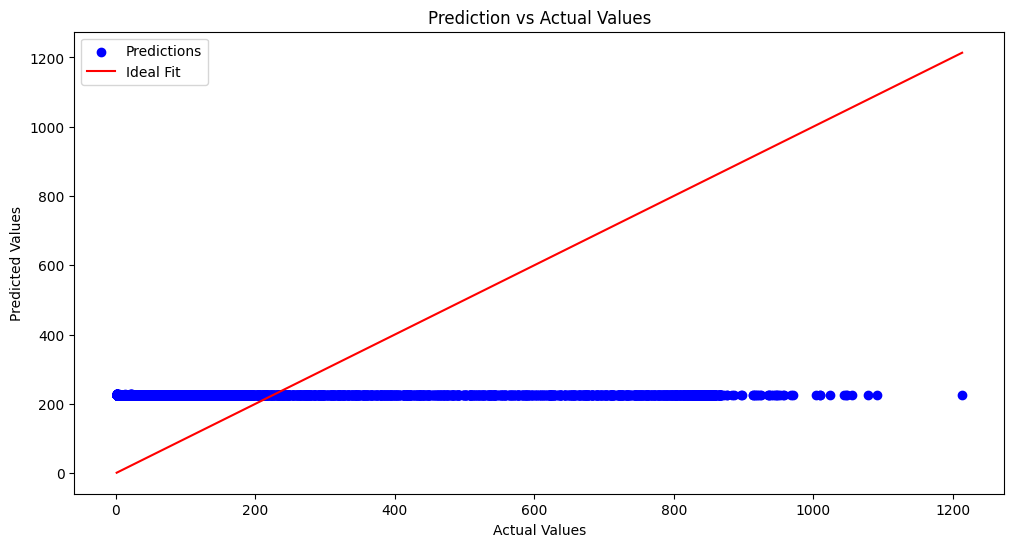

In [48]:
# Plotting Prediction vs Actual Values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Fit')
plt.title('Prediction vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

## **Comparing Both Model**



Epoch 0, Loss: 159480.1313
Epoch 100, Loss: 104747.5556
Epoch 200, Loss: 104747.5480
Epoch 300, Loss: 104747.5440
Epoch 400, Loss: 104747.5440
Epoch 500, Loss: 104747.5440
Epoch 600, Loss: 104747.5440
Epoch 700, Loss: 104747.5440
Epoch 800, Loss: 104747.5440
Epoch 900, Loss: 104747.5440
Machine Learning Model Metrics:
Mean Squared Error (MSE): 32711.0840
Root Mean Squared Error (RMSE): 180.8621
Mean Absolute Error (MAE): 132.2178
R-squared (R²): 0.4479

Deep Learning Model Metrics:
Mean Squared Error (MSE): 64622.7715
Root Mean Squared Error (RMSE): 254.2101
Mean Absolute Error (MAE): 222.3432
R-squared (R²): -0.0906


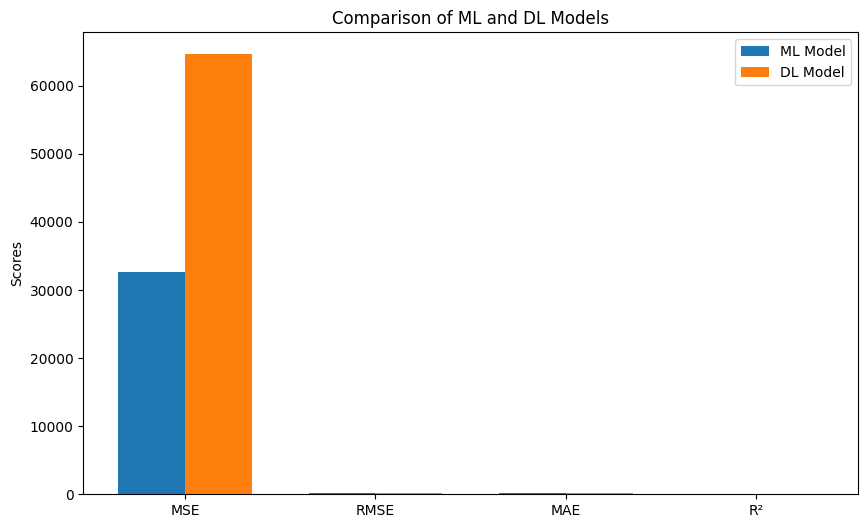

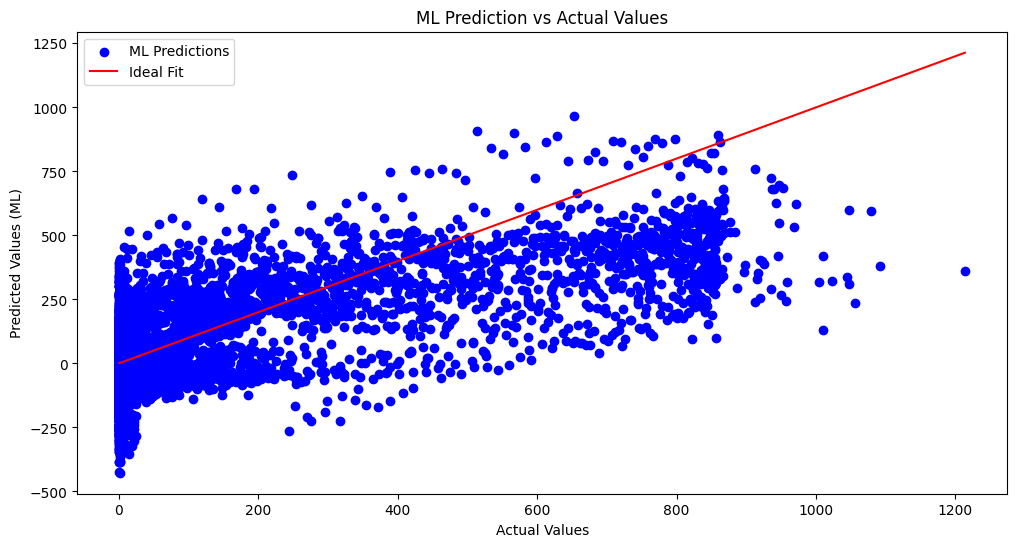

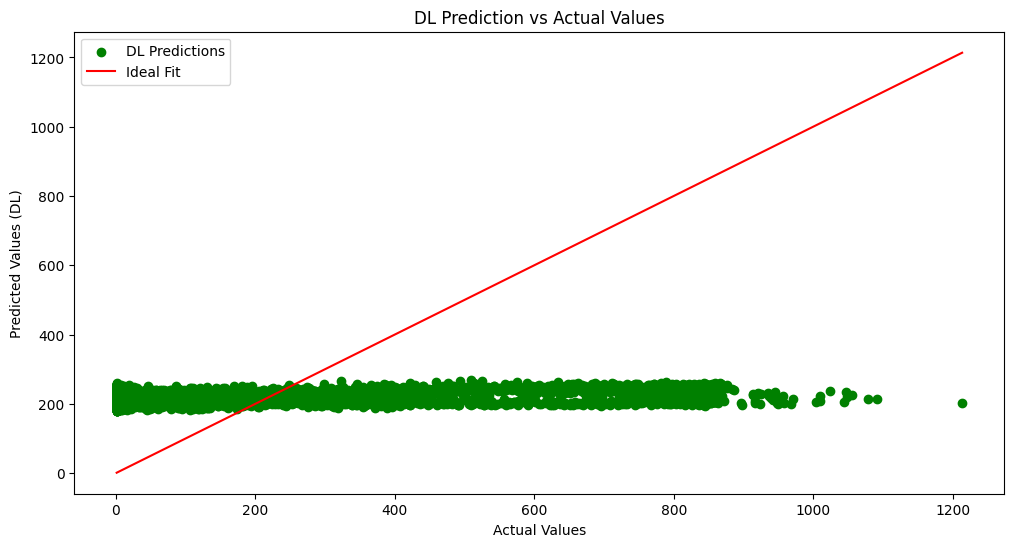

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# --- Assuming you already have X_train_scaled, X_test_scaled, y_train, y_test ---

# --- Machine Learning Model (Linear Regression) ---
ml_model = LinearRegression()

# Train the model
ml_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ml = ml_model.predict(X_test_scaled)

# Calculate metrics for ML model
mse_ml = mean_squared_error(y_test, y_pred_ml)
rmse_ml = np.sqrt(mse_ml)
mae_ml = mean_absolute_error(y_test, y_pred_ml)
r2_ml = r2_score(y_test, y_pred_ml)

# --- Deep Learning Model (Assuming you have NeuralNetwork class already) ---
nn_model = NeuralNetwork(input_size=input_size, hidden_size=hidden_size, output_size=output_size, learning_rate=0.00001)

# Train the deep learning model
nn_model.train(X_train_scaled, y_train, epochs=1000)

# Make predictions using deep learning model
y_pred_nn = nn_model.predict(X_test_scaled).flatten()

# Calculate metrics for Deep Learning model
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

# --- Displaying Results ---
print("Machine Learning Model Metrics:")
print(f"Mean Squared Error (MSE): {mse_ml:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_ml:.4f}")
print(f"Mean Absolute Error (MAE): {mae_ml:.4f}")
print(f"R-squared (R²): {r2_ml:.4f}\n")

print("Deep Learning Model Metrics:")
print(f"Mean Squared Error (MSE): {mse_nn:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_nn:.4f}")
print(f"R-squared (R²): {r2_nn:.4f}")

# --- Plotting the comparison ---
labels = ['MSE', 'RMSE', 'MAE', 'R²']
ml_metrics = [mse_ml, rmse_ml, mae_ml, r2_ml]
nn_metrics = [mse_nn, rmse_nn, mae_nn, r2_nn]

x = np.arange(len(labels))  # The label locations
width = 0.35  # The width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, ml_metrics, width, label='ML Model')
rects2 = ax.bar(x + width/2, nn_metrics, width, label='DL Model')

ax.set_ylabel('Scores')
ax.set_title('Comparison of ML and DL Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# --- Plotting Prediction vs Actual for Both Models ---
# ML Model Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_ml, color='blue', label='ML Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Fit')
plt.title('ML Prediction vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values (ML)')
plt.legend()
plt.show()

# DL Model Plot
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_nn, color='green', label='DL Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal Fit')
plt.title('DL Prediction vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values (DL)')
plt.legend()
plt.show()
